<a href="https://colab.research.google.com/github/MatheusHenriqueDaSilva/data_science/blob/main/compartivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split


In [2]:
# Data understanding
DATA = pd.read_csv('/content/Mall_Customers.csv')
DATA.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
def generate_metadata(dataframe):

    metadata2 = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata2=metadata2.sort_values(by='tipo')
    metadata2 = metadata2.reset_index(drop=True)

    return metadata2

metadados = generate_metadata(DATA)
metadados

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,CustomerID,int64,0,0.0,200
1,Age,int64,0,0.0,51
2,Annual Income (k$),int64,0,0.0,64
3,Spending Score (1-100),int64,0,0.0,84
4,Gender,object,0,0.0,2


In [9]:
card_cutoff = 1
df_categ_labelenc = metadados[(metadados['cardinalidade'] > card_cutoff) & (metadados['tipo'] == 'object')]
lista_lenc = list(df_categ_labelenc.nome_variavel.values)

print('Lista de vars para Label Encoding: ',lista_lenc)

Lista de vars para Label Encoding:  ['Gender']


In [10]:
from sklearn.preprocessing import LabelEncoder
encoders = {}

for col in lista_lenc:
    encoder = LabelEncoder()
    DATA[col] = encoder.fit_transform(DATA[col])

    # Armazena o encoder para a coluna atual em um dicionário
    encoders[col] = encoder

# Salva o dicionário de encoders e a lista de colunas em um arquivo .pkl
data_to_serialize = {
    'encoders': encoders,
    'columns': lista_lenc
}

with open('/content/labelenc.pkl', 'wb') as f:
    pickle.dump(data_to_serialize, f)
data_to_serialize

{'encoders': {'Gender': LabelEncoder()}, 'columns': ['Gender']}

In [11]:
from sklearn.preprocessing import StandardScaler
# Instanciando o scaler
scaler = StandardScaler()

# Padronizando a base de treino
DATA_scaled = scaler.fit_transform(DATA)
DATA_lab_pad = pd.DataFrame(DATA_scaled, columns=DATA.columns, index=DATA.index)

# Salva o scaler em um arquivo .pkl
with open('/content/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
DATA_lab_pad.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,-1.723412,1.128152,-1.424569,-1.738999,-0.434801
1,-1.706091,1.128152,-1.281035,-1.738999,1.195704
2,-1.688771,-0.886405,-1.352802,-1.700830,-1.715913
3,-1.671450,-0.886405,-1.137502,-1.700830,1.040418
4,-1.654129,-0.886405,-0.563369,-1.662660,-0.395980


In [12]:
DATA_lab_pad.shape

(200, 5)

In [100]:
lista_spec = ['Gender', 'CustomerID','Age']
DATA_lab_pad_fil = DATA_lab_pad.drop(lista_spec,axis=1)
DATA_lab_pad_fil

,Annual Income (k$),Spending Score (1-100)
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980
...,...,...
195,2.268791,1.118061
196,2.497807,-0.861839
197,2.497807,0.923953
198,2.917671,-1.250054


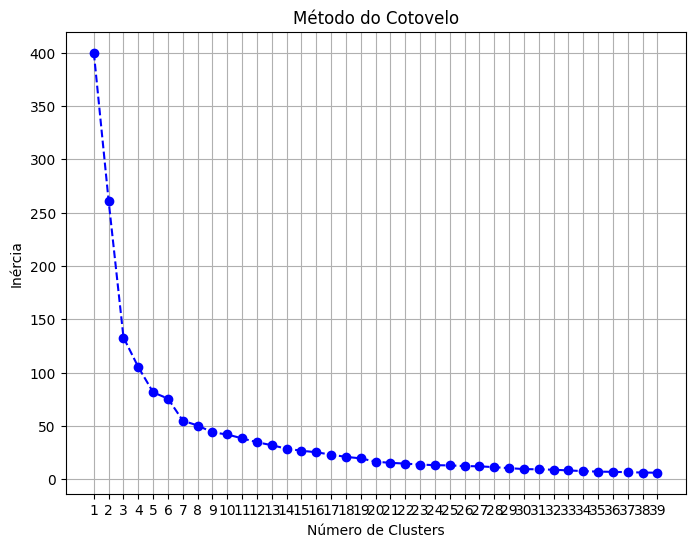

In [53]:
from sklearn.cluster import KMeans

X = DATA_lab_pad_fil

num_rep = 40

# Calcular a inércia para diferentes números de clusters
inertia = []
for i in range(1, num_rep):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init='auto')
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_rep), inertia, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.xticks(range(1, num_rep))
plt.grid(True)
plt.show()

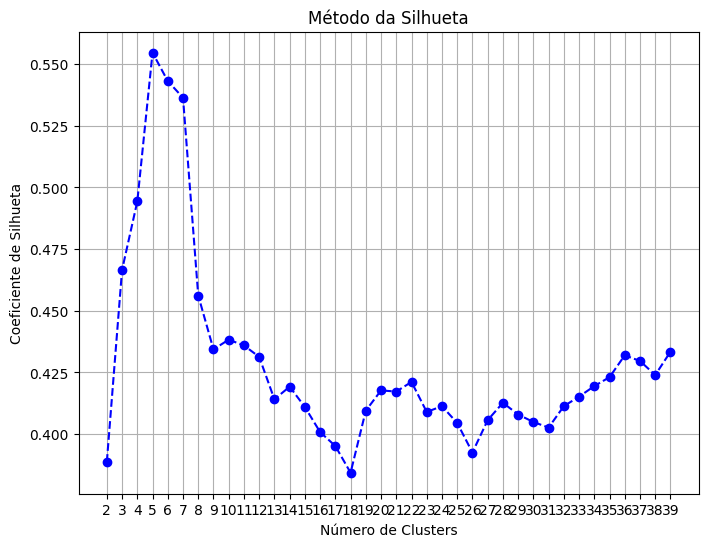

In [44]:
# Calcular a pontuação da silhueta para diferentes números de clusters
from sklearn.metrics import silhouette_score
silhouette_scores = []

num_rep = 40
X = DATA_lab_pad_fil

for n_clusters in range(2, num_rep):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotar o gráfico do método da silhueta
plt.figure(figsize=(8, 6))
plt.plot(range(2, num_rep), silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhueta')
plt.title('Método da Silhueta')
plt.xticks(range(2, num_rep))
plt.grid(True)
plt.show()

In [45]:
# Treinar o algoritmo K-means com K clusters
K=5

kmeans = KMeans(n_clusters=K, random_state=0, n_init='auto')
kmeans.fit(X)

# Obter os centróides dos clusters
centroids = kmeans.cluster_centers_
labels = kmeans.labels_


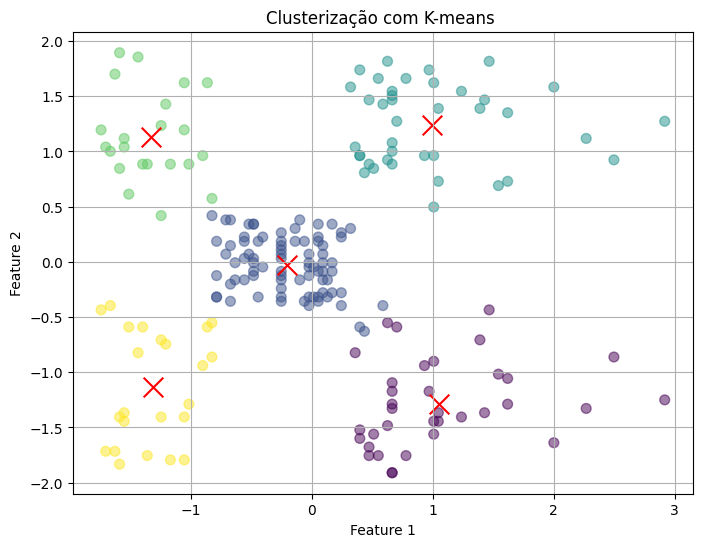

In [46]:
# Visualizar os dados agrupados pelos clusters
plt.figure(figsize=(8, 6))
plt.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, s=50, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, color='red')
plt.title(f'Clusterização com K-means ')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

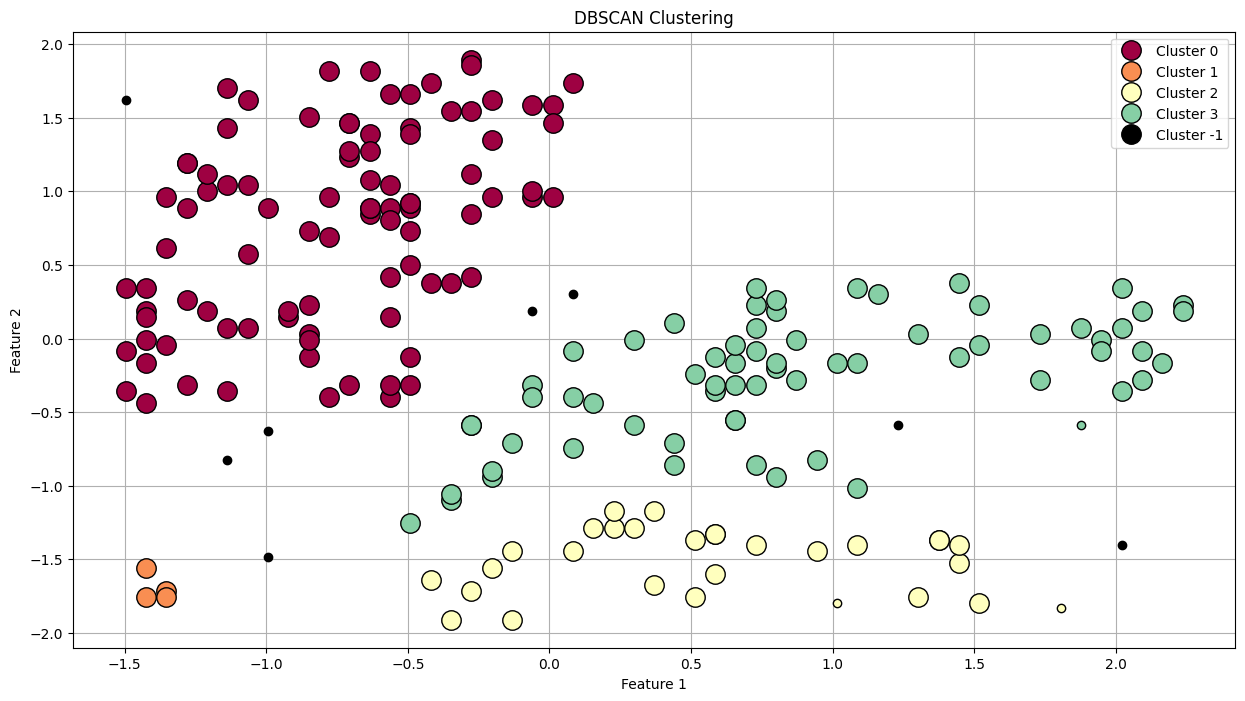

In [65]:
from sklearn.cluster import DBSCAN

X = DATA_lab_pad_fil


# Ajustar o DBSCAN aos dados
dbscan = DBSCAN(eps=0.30, min_samples=3)
dbscan.fit(X)




# Obter os rótulos dos clusters e os rótulos dos outliers
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Número de clusters no rótulo, ignorando o ruído se estiver presente.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Obter cores únicas para cada cluster e outliers
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
core_colors = ['black'] * len(labels)  # Cor para os outliers

# Plotar os pontos com cores de acordo com os rótulos do DBSCAN
plt.figure(figsize=(15, 8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Cor para os outliers
        col = 'black'
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14, label='Cluster {}'.format(k))

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

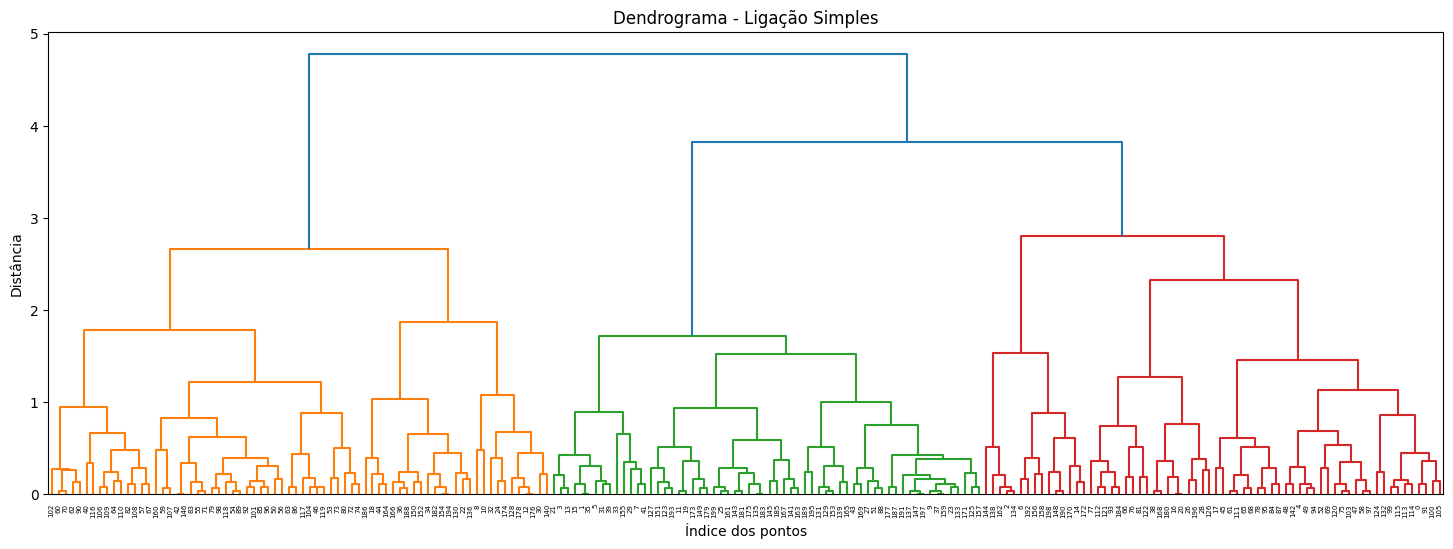

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

X = DATA_lab_pad_fil

# Calcular a ligação simples
Z = linkage(X, method='complete')

# Plotar o dendrograma
plt.figure(figsize=(18, 6))
plt.title('Dendrograma - Ligação Simples')
dendrogram(Z)
plt.xlabel('Índice dos pontos')
plt.ylabel('Distância')
plt.show()

In [107]:
from sklearn.mixture import GaussianMixture

X = DATA_lab_pad_fil

# Inicializar o modelo de Mistura Gaussiana
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)

# Ajustar o modelo aos dados com parâmetros de inicialização específicos
gmm.fit(X)

# Prever os rótulos dos clusters
labels = gmm.predict(X)

# Calcular os centros e os raios dos círculos dos clusters
centers = gmm.means_
covariances = gmm.covariances_
radii = np.sqrt(covariances[:, 0, 0] + covariances[:, 1, 1]) * 2  # Utilize o desvio padrão como raio
labels
X['labels'] = labels
X.head()

,Annual Income (k$),Spending Score (1-100),labels
count,2.000000e+02,2.000000e+02,200.000000
mean,-2.131628e-16,-1.465494e-16,1.640000
std,1.002509e+00,1.002509e+00,1.311104
min,-1.738999e+00,-1.910021e+00,0.000000
25%,-7.275093e-01,-5.997931e-01,1.000000
50%,3.587926e-02,-7.764312e-03,1.000000
75%,6.656748e-01,8.851316e-01,3.000000
max,2.917671e+00,1.894492e+00,4.000000


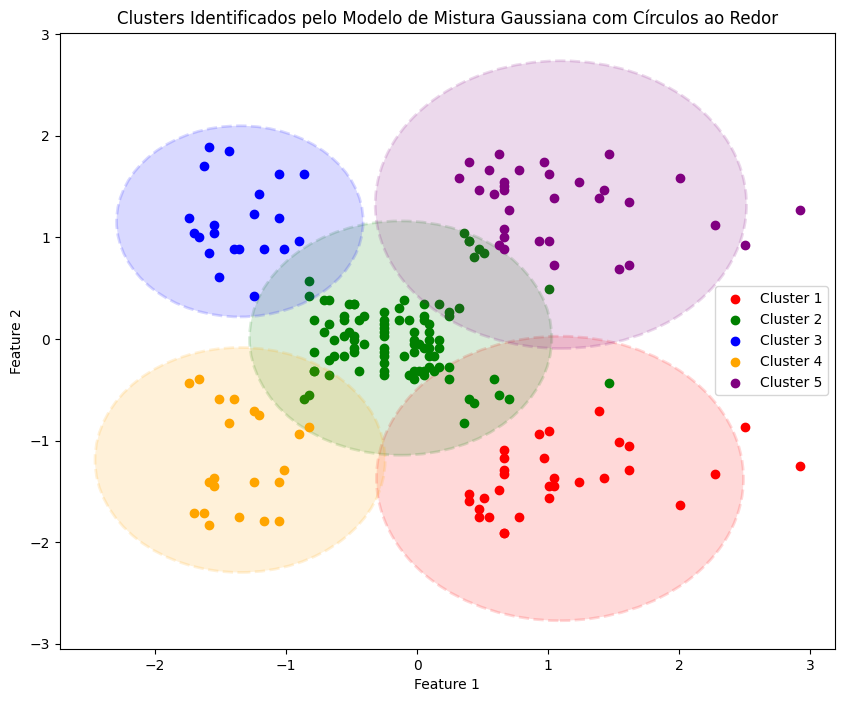

In [111]:

# Plotar os dados com os clusters identificados e círculos ao redor
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue','orange','purple']

for i in range(5):
    plt.scatter(X.iloc[labels == i, 0], X.iloc[labels == i, 1], color=colors[i], label=f'Cluster {i+1}', alpha=1)
    circle = plt.Circle(centers[i], radii[i], color=colors[i], alpha=0.15, fill=True, linestyle='--', linewidth=2)
    plt.gca().add_patch(circle)

plt.title('Clusters Identificados pelo Modelo de Mistura Gaussiana com Círculos ao Redor')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()